<h1>Trabalho 3 - Extração de atributos e Classificação</h1>

In [66]:
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import cv2
import scipy.misc

In [3]:
dados = np.loadtxt('ocr_car_numbers_rotulado.txt')


In [4]:
def getImage(data, row):
    image = data[row, :-1] #seleciona a lilha e apaga o útima coluna
    image.shape = (35, 35) #converte para duas dimensões
    image[image==1]=255
    image = np.uint8(image)
    return image

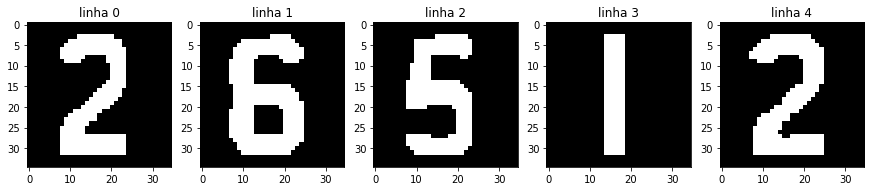

In [5]:
linhas = 5

imgs = [getImage(dados, i) for i in range(len(dados))]

plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(imgs[i], 'gray')


<h3>Código de Cadeia - Seguidores de fronteiras</h3>

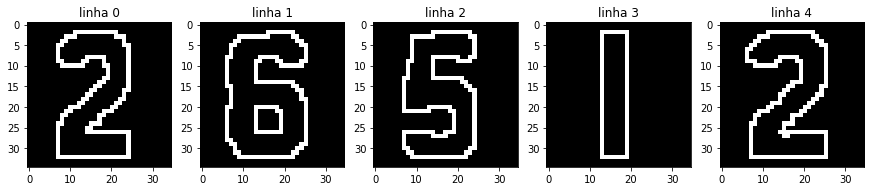

In [6]:
#canny = cv2.Canny(img,100,300)
#edges = canny.copy()

kernel = np.ones((3,3), np.uint8)
edges = [cv2.dilate(img, kernel, iterations=1) - img for img in imgs] #array de bordas do array de imagens
 
plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(edges[i], 'gray')


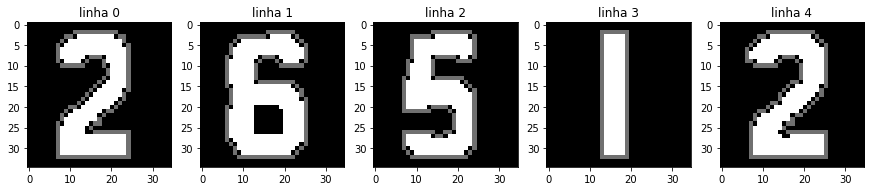

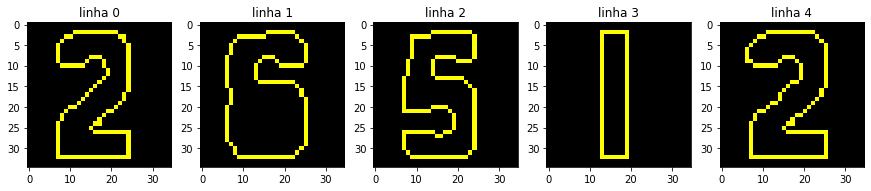

In [7]:
newImgs = []
n_contours = []

for i in range(len(edges)):
    contours, hierarchy = cv2.findContours(edges[i],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    n_contours.append(contours)

    maior = 0 #descobrir qual conjunto de contornos tem mais pontos
    for sizet in range(len(contours)):
        if (len(contours[sizet])>maior):
            maior = sizet

    newImg = np.zeros([35,35,3])
    newImg = np.uint8(newImg)

    for ind_contour in range(len(contours)):

        imgs[i] = cv2.polylines(imgs[i][:],contours,True,(112,255,255),1)#desenhando o poligono de acordo com os pontos
        newImg = cv2.polylines(newImg,contours,True,(0,255,255),1)#desenhando o poligono de acordo com os pontos
        
    newImgs.append(newImg)
    
plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(imgs[i], 'gray')
    
plt.figure(figsize=(15,10))
for i in range(linhas):
    newImgs[i] = cv2.cvtColor(newImgs[i], cv2.COLOR_BGR2RGB)
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(newImgs[i], 'gray')

In [8]:
def getChainCode(x1, y1, x2, y2): 
    dx = x2 - x1 
    dy = y2 - y1 
    
    if dx>0: #Significa que as posições podem ser (5,4,3)
        if dy <0 :
            code = 5
        elif dy==0:
            code = 4
        else:
            code = 3

    elif dx==0: # Significa que as posicoes podem ser (6,2)
        if dy<0:
            code = 6
        elif dy>0:
            code = 2
        else:
            code=8
    else: #Significa que as posicoes podem ser (7,0,1)
        if dy<0:
            code = 7
        elif dy==0:
            code = 0
        else:
            code = 1

    return code 

In [9]:
def generateChainCode(ListOfPoints): 
    chainCode = [] 
    textChain = " "
    for i in range(len(ListOfPoints)):
        a = ListOfPoints[i][0]
        #print("valor de A = ",a[0],a[1]) 
        if i != len(ListOfPoints)-1:
            b = ListOfPoints[i + 1][0]
            #print("valor de B = ",b[0],b[1])
        else :
            b = ListOfPoints[0][0] 
        chainCode.append(getChainCode(a[0], a[1], b[0], b[1]))
        textChain = textChain + str(getChainCode(a[0], a[1], b[0], b[1]))
        textChainT = str(getChainCode(a[0], a[1], b[0], b[1]))
        #DESCOMENTAR A LINHA ABAIXO PARA MOSTRAR O CODIGO DE CADA PONTO
        #cv2.putText(edges,textChainT, (a[0],a[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1,cv2.LINE_AA)
    return chainCode,textChain 

In [10]:
def box(signal, smaller):
    
    index = 0
    newSignal = []
    prop = len(signal)/smaller
    d = prop
    
    while len(newSignal) < smaller:
        
        newSignal.append(signal[index])
        i, d = divmod(d, 1) #separa a pater inteira da parte decimal
        index += int(i) #adiciona a parte inteira ao indice
        d += prop #adiciona ao resto a proporcao        
        
    return newSignal   


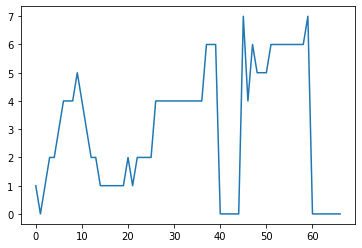

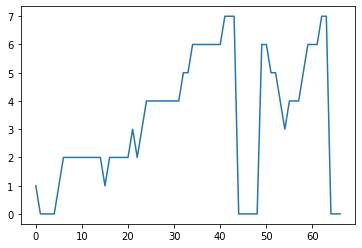

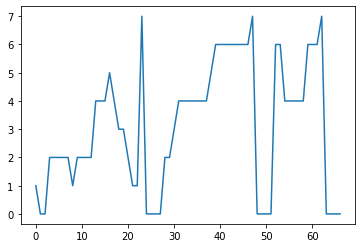

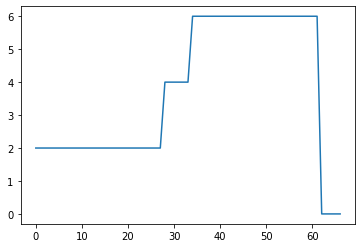

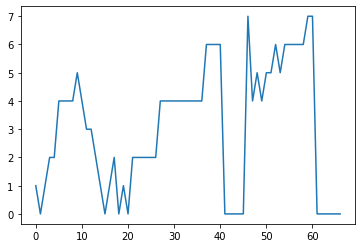

In [85]:
chainCodes = []

for contours in n_contours:
    chainCode,tsx = generateChainCode(contours[0])
    chainCodes.append(chainCode)
    #print("chain code ",ind_contour," = ", tsx)
    #print("sum ",ind_contour," = ",sum(chainCode))
    #print("Quantidade de pontos =",len(contours[ind_contour]))
    
smaller = min([len(chainCode) for chainCode in chainCodes]) #pega o comprimento da menor cadeia
chainCodes = [box(chainCode, smaller) for chainCode in chainCodes] #faz a normalização das cadeias
#chainCodes = [[chainCode, dado[-1]] for chainCode in chainCodes for dado in dados]

chainCodes = np.array(chainCodes)
    
for i in range(5):
    plt.plot(chainCodes[i])
    plt.show()


In [15]:
def normalizeImage(v):
  v = (v - v.min()) / (v.max() - v.min())
  result = (v * 255).astype(np.uint8)
  return result

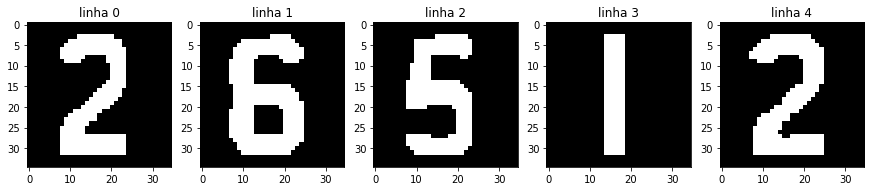

In [16]:
imgs = [getImage(dados, i) for i in range(len(dados))]
imgs = [normalizeImage(img) for img in imgs]

plt.figure(figsize=(15,10))
for i in range(linhas):
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(imgs[i], 'gray')

In [17]:
def centroid(img):
    ret,thresh = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
    height, width = thresh.shape[:2]

    mass = 0
    Xcm  = 0.0
    Ycm  = 0.0

    for i in range(width) :
        for j in range(height) :
            if not thresh[j][i] :
                mass += 1
                Xcm  += i
                Ycm  += j

    return  [Ycm/mass, Xcm/mass]

In [18]:
def signature(image):
    sign = []
    contours, _ = cv2.findContours(image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    center = centroid(image)
    for i in range(len(contours[0])):
        point = contours[0][i][0]
        dist = np.linalg.norm(point-center)
        sign.append(dist)
    
    return sign

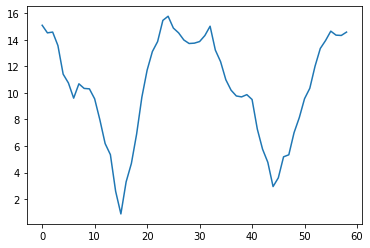

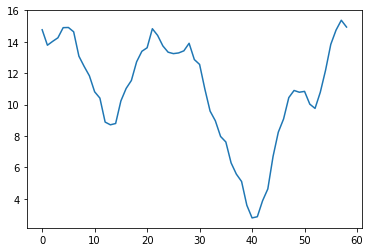

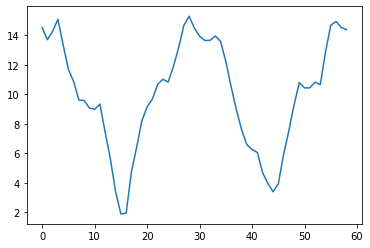

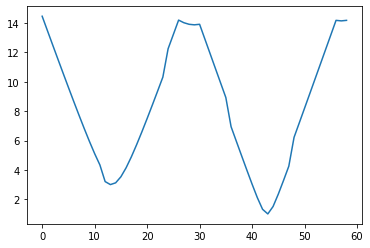

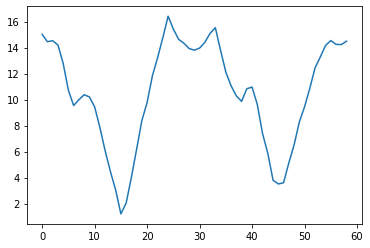

In [95]:
signatures = [signature(img) for img in imgs]

smaller = min([len(signature) for signature in signatures]) #pega o comprimento da menor cadeia
signatures = [box(signature, smaller) for signature in signatures] #faz a normalização das cadeias

signatures = np.array(signatures)

for i in range(5):
    plt.plot(signatures[i])
    plt.show()

In [20]:
n_contours[0]
convexHulls = [cv2.convexHull(contours[0]) for contours in n_contours]


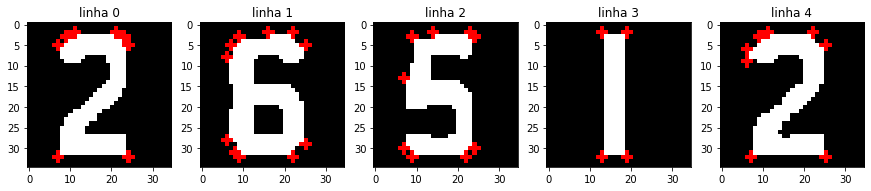

In [21]:
newImgs = []

for i in range(len(edges)):    
        
    newImg = np.zeros([35,35,3])
    newImg = np.uint8(newImg)
    newImg[:,:,0] = newImg[:,:,1] = newImg[:,:,2] = imgs[i]

    for ind_contour in range(len(contours)):
        newImg = cv2.drawContours(newImg, convexHulls[i], -1, (0,0,255), 2)       
        
    newImgs.append(newImg)
    
plt.figure(figsize=(15,10))
for i in range(linhas):
    newImgs[i] = cv2.cvtColor(newImgs[i], cv2.COLOR_BGR2RGB)
    plt.subplot(1,linhas,i+1)
    plt.subplot(1,linhas,i+1).set_title('linha ' + str(i))
    plt.imshow(newImgs[i], 'gray')

In [26]:
def LBP_FE(image):
        lbp_image = local_binary_pattern(image, 256, 1, "uniform")
        return np.histogram(lbp_image.ravel(), bins=256)

def HU_FE(image):
        moments = cv2.moments(image.astype(np.float64))
        return np.asarray( cv2.HuMoments(moments).flatten())

def GLCM_FE(image):
        glcm = greycomatrix(image, [1], [0], 256, symmetric=True, normed=True)
        xs = []
        xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        xs.append(greycoprops(glcm, 'correlation')[0, 0])
        xs.append(greycoprops(glcm, 'homogeneity')[0, 0])
        xs.append(greycoprops(glcm, 'ASM')[0, 0])
        xs.append(greycoprops(glcm, 'energy')[0, 0])
        xs.append(greycoprops(glcm, 'correlation')[0, 0])
        return np.asarray(xs);


In [155]:
GLCM_FEs = [GLCM_FE(img) for img in imgs]
GLCM_FEs = np.array(GLCM_FEs)

In [156]:
print(GLCM_FEs[0])
print(GLCM_FEs[1])
print(GLCM_FEs[2])
print(GLCM_FEs[3])
print(GLCM_FEs[4])

[13.28571429  0.8510993   0.94789996  0.6007104   0.7750551   0.8510993 ]
[16.28571429  0.84619048  0.93613544  0.52498835  0.7245608   0.84619048]
[13.71428571  0.85341217  0.94621931  0.58222159  0.76303446  0.85341217]
[12.42857143  0.7722488   0.95126125  0.73963279  0.86001907  0.7722488 ]
[13.71428571  0.85200386  0.94621931  0.58571287  0.76531881  0.85200386]


In [217]:
signatures.shape

(3352, 59)

In [224]:
from sklearn.model_selection import train_test_split
X = chainCodes
Y = dados[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=84)

In [225]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam


In [226]:
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [227]:
model = Sequential()
model.add(Dense(512, input_dim=67, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) #Otimização do modelo

In [230]:
h = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.3)

Epoch 1/10
59/59 [==============================] - 0s 7ms/step - loss: 0.1443 - accuracy: 0.9179 - val_loss: 0.1241 - val_accuracy: 0.9354
Epoch 2/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1407 - accuracy: 0.9200 - val_loss: 0.1211 - val_accuracy: 0.9093
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1304 - accuracy: 0.9259 - val_loss: 0.1206 - val_accuracy: 0.9255
Epoch 4/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1422 - accuracy: 0.9334 - val_loss: 0.1846 - val_accuracy: 0.9081
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1306 - accuracy: 0.9344 - val_loss: 0.1314 - val_accuracy: 0.9130
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1269 - accuracy: 0.9302 - val_loss: 0.1894 - val_accuracy: 0.9143
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1326 - accuracy: 0.9451 - val_loss: 0.1375 - val_accuracy: 0.9230
Epoch 8/10
59/59 [==

In [231]:
results = model.evaluate(X_test, y_test_cat)
print('Train: ', results[1])

21/21 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9508
Train:  0.9508196711540222


Text(0.5, 0, 'Epochs')

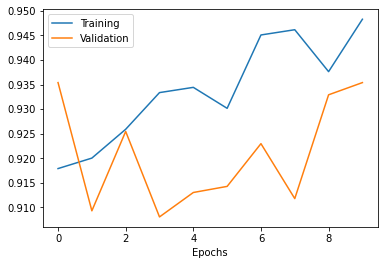

In [239]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epochs')